In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Week 1

In [2]:
inflows = pd.read_parquet('data/ucsd-inflows.pqt')
outflows = pd.read_parquet('data/ucsd-outflows.pqt')

display(inflows.head(), outflows.head())

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,PAYCHECK,2477.02,2022-03-18,PAYCHECK
1,0,acc_0,EXTERNAL_TRANSFER,100.00,2022-10-25,EXTERNAL_TRANSFER
2,0,acc_0,MISCELLANEOUS,6.29,2022-08-26,MISCELLANEOUS
3,0,acc_0,EXTERNAL_TRANSFER,277.00,2022-06-03,EXTERNAL_TRANSFER
4,0,acc_0,EXTERNAL_TRANSFER,100.00,2022-07-29,EXTERNAL_TRANSFER


,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,LOAN,900.60,2022-07-05,LOAN
1,0,acc_0,ATM_CASH,80.00,2022-03-25,ATM_CASH
2,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.42,2022-09-26,FOOD_AND_BEVERAGES
3,0,acc_0,LOAN,634.00,2023-01-10,LOAN
4,0,acc_0,Buffalo Wild Wings,26.47,2022-09-12,FOOD_AND_BEVERAGES


In [3]:
outflows.posted_date = pd.to_datetime(outflows.posted_date)

I create a subset of `outflows` that doesn't include rows where `memo == category` because these are the rows that we train our model on to predict `category`.

In [4]:
outflows_with_memo = outflows[~(outflows.memo == outflows.category)].reset_index().drop(columns='index')
outflows_with_memo.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.42,2022-09-26,FOOD_AND_BEVERAGES
1,0,acc_0,Buffalo Wild Wings,26.47,2022-09-12,FOOD_AND_BEVERAGES
2,0,acc_0,Oculus CA 04/16,11.73,2022-04-18,GENERAL_MERCHANDISE
3,0,acc_0,LOS GIRASOLES STOW OH 03/08,30.04,2022-03-09,FOOD_AND_BEVERAGES
4,0,acc_0,BUZZIS LAUNDRY 1 OH 03/28,4.16,2022-03-29,GENERAL_MERCHANDISE


#### EDA

## WEEK 2 - Train Test Split

In [12]:
from sklearn.model_selection import train_test_split

#### Sample by consumer instead of transaction to avoid sampling bias

**From here on out, I only work with `outflows_with_memo` because that is the subset of the data we were told to work with.** This doesn't include rows where `memo == category`, and thereby includes rows that are pivotal to our prediction task.

In [6]:
def dataset_split(dataset):
    # get unique consumer ids
    ids = dataset.prism_consumer_id.unique()
    train_ids, test_ids = train_test_split(ids, test_size=0.25)

    # split customer_ids into train and test sets
    train = dataset[dataset['prism_consumer_id'].isin(train_ids)]
    test = dataset[dataset['prism_consumer_id'].isin(test_ids)]

    return train, test

In [7]:
outflows_memo_train, outflows_memo_test = dataset_split(outflows_with_memo)

For the subset of outflows that doesn't have the category given in the memo

In [8]:
print(f'# of unique IDS: {len(outflows_with_memo.prism_consumer_id.unique())}, # of unique train IDS: {len(outflows_memo_train.prism_consumer_id.unique())}, # of unique test IDS: {len(outflows_memo_test.prism_consumer_id.unique())}')

# of unique IDS: 2952, # of unique train IDS: 2214, # of unique test IDS: 738


In [9]:
outflows_with_memo.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,prism_consumer_id,amount,posted_date
count,1306452.00000,1306452.00000,1306452.00000
mean,3182.59410,53.89793,.5f
min,0.00000,0.00000,.5f
25%,1501.00000,9.00000,.5f
50%,3421.00000,19.47000,.5f
75%,4787.00000,42.58000,.5f
max,5943.00000,280171.35000,.5f
std,1801.11219,635.18547,nan


In [10]:
outflows_memo_train.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,prism_consumer_id,amount,posted_date
count,972733.00000,972733.00000,972733.00000
mean,3174.06699,51.89812,.5f
min,0.00000,0.00000,.5f
25%,1458.00000,9.04000,.5f
50%,3392.00000,19.56000,.5f
75%,4827.00000,43.00000,.5f
max,5943.00000,280171.35000,.5f
std,1807.21368,447.85473,nan


In [11]:
outflows_memo_test.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,prism_consumer_id,amount,posted_date
count,333719.00000,333719.00000,333719.00000
mean,3207.44914,59.72703,.5f
min,7.00000,0.00000,.5f
25%,1597.00000,8.97000,.5f
50%,3495.00000,19.21000,.5f
75%,4660.00000,41.28500,.5f
max,5939.00000,279412.00000,.5f
std,1782.97831,997.39507,nan


#### TODO include statistical tests to ensure distributions are similar

## WEEK 3 - Memo Cleaning

In [12]:
outflows_with_memo.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.42,2022-09-26,FOOD_AND_BEVERAGES
1,0,acc_0,Buffalo Wild Wings,26.47,2022-09-12,FOOD_AND_BEVERAGES
2,0,acc_0,Oculus CA 04/16,11.73,2022-04-18,GENERAL_MERCHANDISE
3,0,acc_0,LOS GIRASOLES STOW OH 03/08,30.04,2022-03-09,FOOD_AND_BEVERAGES
4,0,acc_0,BUZZIS LAUNDRY 1 OH 03/28,4.16,2022-03-29,GENERAL_MERCHANDISE


#### Memo cleaning steps:
- did more complex preprocessing first 
    - lemmatizer? (might not be good for this because it could stem words it shouldn't
    - same thing for stop words
    - remove dates (regex search mm/yy) and location addresses
    - get rid of email addresses -- TODO 
    - trans 1 @ $1.00 -- TODO
- simple preprocessing
    - lowercase 
    - remove punctuation (,-*#_')
    - remove XXXX, even amount of X's
    - remove purchase authorized on
    - remove purchase, checkcard
- should not preprocess memos that are the same category

In [13]:
# memos[memos.str.contains('@')].values[:1000]

In [14]:
# # looking at 
# test = memos.str.replace(r'trans \d+ @ \$\d+\.\d{2}', 'testing', regex=True)
# test[(test.str.contains('@'))].values[:1000]

In [15]:
# memos[(memos.str.contains('@'))].values[:1000]

In [5]:
def clean_memos(dataset):
    memos = dataset.memo
    pattern1 = r'\b\w*x{2,}\w*\b'
    pattern2 = r'\b(0[1-9]|1[0-2])(\/|-)[0-9]{2}\b'
    pattern3 = r"[,'*#_-]"

    cleaned_memos = (
        memos.str.lower()
            .str.replace(pattern1, '', regex=True)                   # removing XXXX                        
            .str.replace(pattern2, '', regex=True)                   # removing dates
            .str.replace(pattern3, '', regex=True)                   # removing unnecessary special characters
            .str.replace(r'~', '', regex=True)                       # removing ~ (can't include in character class above)
            .str.replace('purchase.* authorized on', '', regex=True) # removing common phrase
            .str.replace('checkcard', '')                            # removing common phrase
            .str.strip()                                             # removing leading and trailing characters
    )

    cleaned_memos = cleaned_memos.reset_index().drop(columns='index').squeeze()
    dataset['cleaned_memo'] = cleaned_memos

    return dataset

In [6]:
outflows_with_memo = clean_memos(outflows_with_memo)

In [10]:
memos = outflows_with_memo.memo
cleaned_memos = outflows_with_memo.cleaned_memo

In [19]:
memos.unique().__len__(), cleaned_memos.unique().__len__(), 

(528766, 307409)

In [20]:
memos_counts = memos.value_counts()
cleaned_memos_counts = cleaned_memos.value_counts()

In [21]:
memos_counts

memo
Amazon                    31725
Walmart                   31619
McDonald's                22670
Starbucks                 12777
7-Eleven                  11675
                          ...  
Academy Sports #194           1
Casa Marina Hotel & Re        1
Doordash Breakfast Bow        1
Doordash Seafood Expre        1
Flp Llc XXXXXXXXXX            1
Name: count, Length: 528766, dtype: int64

In [22]:
cleaned_memos_counts

cleaned_memo
walmart                                                                                             32099
amazon                                                                                              31737
mcdonalds                                                                                           27598
starbucks                                                                                           12823
7eleven                                                                                             11821
                                                                                                    ...  
pos withdrawalarco  ampm  n 19th us phoenix az  card 15   mcc                                           1
debit card withdrawal purchaseamzn mktp ussp67x25a3 amzn.com/bill wa date /23 purch   card 15 34        1
debit card withdrawal purchaseaudible amzn.com/bill nj date /23 purch   card 15  %                      1
debit card withdrawal purchasejac

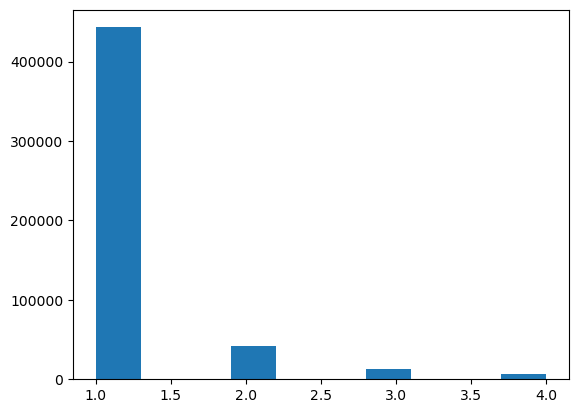

In [23]:
plt.hist(memos_counts[memos_counts < 5])
plt.show()

In [24]:
(memos_counts == 1).sum()

443287

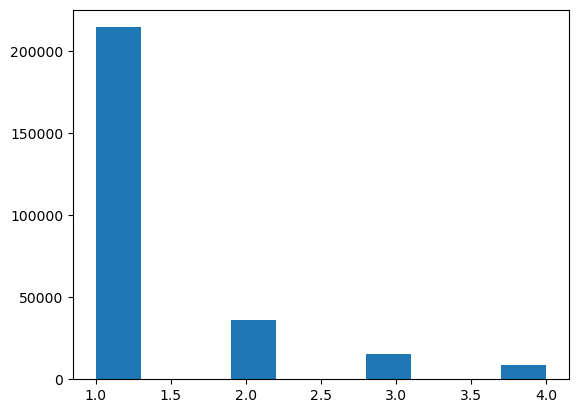

In [25]:
plt.hist(cleaned_memos_counts[cleaned_memos_counts < 5])
plt.show()

In [26]:
(cleaned_memos_counts == 1).sum()

214737

## Week 4

In [27]:
outflows_with_memo.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,cleaned_memo
0,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.42,2022-09-26,FOOD_AND_BEVERAGES,tst casa del rio exp fairlawn oh
1,0,acc_0,Buffalo Wild Wings,26.47,2022-09-12,FOOD_AND_BEVERAGES,buffalo wild wings
2,0,acc_0,Oculus CA 04/16,11.73,2022-04-18,GENERAL_MERCHANDISE,oculus ca
3,0,acc_0,LOS GIRASOLES STOW OH 03/08,30.04,2022-03-09,FOOD_AND_BEVERAGES,los girasoles stow oh
4,0,acc_0,BUZZIS LAUNDRY 1 OH 03/28,4.16,2022-03-29,GENERAL_MERCHANDISE,buzzis laundry 1 oh


### Creating Features

#### TF-IDF

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
def get_tfidf_features(dataset, max_features):
    cleaned_memos = dataset.cleaned_memo
    vectorizer = TfidfVectorizer(max_features=max_features)
    tfidf = vectorizer.fit_transform(cleaned_memos)
    
    tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf)
    tfidf_df.columns = 'tfidf_' + vectorizer.get_feature_names_out()
    
    return tfidf_df

#### Dates and Amounts

**Date Features**
- month of year -- charges change by month (increase in food_and_beverages in summer, general_merchandise during holidays, travel)
- day of week -- charges change by day (weekend may see more food spending, weekday for groceries)
- day of month -- beginning of month charges (rent) vs middle of month charges (utilities) vs end of month (credit card?)

In [30]:
from sklearn.preprocessing import OneHotEncoder

In [31]:
def get_date_features(dataset):
    posted_date = dataset.posted_date
    date_features = pd.DataFrame()
    
    date_features['month'] = 'month_' + posted_date.dt.month.astype(str)
    date_features['weekday'] = 'weekday_' + posted_date.dt.weekday.astype(str)
    date_features['day_of_month'] = 'day_of_month_' + posted_date.dt.day.astype(str)

    date_enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    date_one_hot = date_enc.fit_transform(date_features)

    date_columns = np.concatenate([feature[1:] for feature in date_enc.categories_])
    date_one_hot_df = pd.DataFrame.sparse.from_spmatrix(date_one_hot, columns=date_columns)

    return date_one_hot_df

**Amount Features**
- is even amount (x.00)
- bin the amounts based on size
    - potentially by category as well?

In [32]:
def get_amount_features(dataset):
    amount = dataset.amount

    amount_features = pd.DataFrame()
    amount_features['is_even'] = amount.apply(lambda x: 'amount_even' if x % 1 == 0 else 'amount_odd')
    amount_features['decile_amounts'] = pd.qcut(amount, q=10, labels=['decile_0', 'decile_1', 'decile_2', 'decile_3', 'decile_4', 'decile_5', 'decile_6', 'decile_7', 'decile_8', 'decile_9'])

    amount_enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    amount_one_hot = amount_enc.fit_transform(amount_features)

    amount_columns = np.concatenate([feature[1:] for feature in amount_enc.categories_])
    amount_one_hot_df = pd.DataFrame.sparse.from_spmatrix(amount_one_hot, columns=amount_columns)
    
    return amount_one_hot_df

### Putting Features Together

In [33]:
def get_features_df(dataset, tfidf_max_features):
    tfidf_df = get_tfidf_features(dataset, tfidf_max_features)
    date_df = get_date_features(dataset)
    amount_df = get_amount_features(dataset)

    features_df =  pd.concat([dataset, tfidf_df, date_df, amount_df], axis=1)
    return features_df

In [34]:
def train_test_split_features(dataset, tfidf_max_features):
    features_df = get_features_df(dataset, tfidf_max_features)
    train_df, test_df = dataset_split(features_df)
    
    X_train = train_df.iloc[:, 7:]
    y_train = train_df['category']
    X_test = test_df.iloc[:, 7:]
    y_test = test_df['category']

    X_train.columns = X_train.columns.astype(str)
    X_test.columns = X_test.columns.astype(str)

    return X_train, y_train, X_test, y_test

In [36]:
X_train, y_train, X_test, y_test = train_test_split_features(outflows_with_memo, tfidf_max_features=50)

In [37]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((982639, 107), (982639,), (323813, 107), (323813,))

### Training Models

In [38]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns

#### Logistic Regression

In [39]:
def fit_model(X_train, y_train, model_type):
    if model_type == 'log_reg':
        model = LogisticRegression(max_iter=1000, random_state=0, n_jobs=-1).fit(X_train, y_train)
    elif model_type == 'xgboost':
        le = LabelEncoder()
        y_train_encoded = le.fit_transform(y_train)

        # hyperparameters to consider: n_estimators, max_depth, learning_rate
        model = XGBClassifier(objective='multi:softmax')
        model.fit(X_train, y_train_encoded)

        return model, le

    return model

In [40]:
def predict(X, y, model, le=None):
    if isinstance(model, LogisticRegression):
        preds = model.predict(X)
    elif isinstance(model, XGBClassifier):
        preds_encoded = model.predict(X)
        preds = le.inverse_transform(preds_encoded)
    
    print(f"Accuracy: {(preds == y).mean():.3f}")
    
    return preds

In [41]:
def fit_and_predict(X_train, y_train, X_test, y_test, model_type):
    if model_type == 'log_reg':
        model = LogisticRegression(max_iter=1000, random_state=0, n_jobs=-1).fit(X_train, y_train) 
        preds_train = model.predict(X_train)
        preds_test = model.predict(X_test)
        
    elif model_type == 'xgboost':
        le = LabelEncoder()
        y_train_encoded = le.fit_transform(y_train)

        # hyperparameters to consider: n_estimators, max_depth, learning_rate
        model = XGBClassifier(objective='multi:softmax')
        model.fit(X_train, y_train_encoded)

        preds_train_encoded = model.predict(X_train)
        preds_test_encoded = model.predict(X_test)
        
        preds_train = le.inverse_transform(preds_train_encoded)
        preds_test = le.inverse_transform(preds_test_encoded)

    print(f"Train accuracy: {(preds_train == y_train).mean()}, Test accuracy: {(preds_test == y_test).mean()}")
    
    return model, preds_train, preds_test

In [42]:
# for i in range(len(coef_df)):
#     display(coef_df.iloc[i].abs().sort_values(ascending=False).iloc[:10])

**Accuracy by category**

In [43]:
def make_confusion_matrices(y_train, preds_train, y_test, preds_test):
    
    def make_conf_matrix(y, preds):
        conf_matrix = confusion_matrix(y, preds, labels=y.unique(), normalize='pred')
        classes = y.value_counts().sort_values(ascending=False).index
        conf_matrix_df = pd.DataFrame(conf_matrix, index=classes, columns=classes)
        return conf_matrix_df

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 13))
    conf_matrix_train = make_conf_matrix(y_train, preds_train)
    sns.heatmap(conf_matrix_train, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True, 
                linewidths=0.5, linecolor='gray', square=True, annot_kws={"size": 8}, ax=ax1)
    ax1.set_title('Train Precision')
    ax1.set_xlabel('Predicted Labels')
    ax1.set_ylabel('True Labels')
    
    conf_matrix_test = make_conf_matrix(y_test, preds_test)
    sns.heatmap(conf_matrix_test, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True, 
                linewidths=0.5, linecolor='gray', square=True, annot_kws={"size": 8}, ax=ax2)
    ax2.set_title('Test Precision')
    ax2.set_xlabel('Predicted Labels')
    ax2.set_ylabel('True Labels')

    plt.tight_layout(rect=[0.0, 0.0, 1, 1])
    plt.subplots_adjust(wspace=0.5, hspace=0.55)
    plt.show()

In [ ]:
%%time
# tfidf generation taking longer than log reg model fitting
# 3000 tfidf taking close to 2 min
X_train, y_train, X_test, y_test = train_test_split_features(outflows_with_memo, tfidf_max_features=4000)

In [43]:
%%time
log_reg = fit_model(X_train, y_train, 'log_reg')

CPU times: user 2.56 s, sys: 782 ms, total: 3.34 s
Wall time: 1min 33s


In [44]:
preds_train = predict(X_train, y_train, log_reg)

Accuracy: 0.960


In [45]:
preds_test = predict(X_test, y_test, log_reg)

Accuracy: 0.944


In [ ]:
bst, le = fit_model(X_train, y_train, 'xgboost')

In [ ]:
predict(X_train, y_train, bst, le)

In [ ]:
%%time
# 500 tfidf - 61 seconds - Train accuracy: 0.873, Test accuracy: 0.863
# 750 tfidf - 62 seconds - Train accuracy: 0.895, Test accuracy: 0.889
# 1000 tfidf - 63 seconds - Train accuracy: 0.911, Test accuracy: 0.906
# 2000 tfidf - 66 seconds - Train accuracy: 0.938, Test accuracy: 0.927
# 3000 tfidf - 77 seconds - Train accuracy: 0.952, Test accuracy: 0.939
# 5000 tfidf - 68 seconds - Train accuracy: 0.964, Test accuracy: 0.941
log_reg, preds_train, preds_test = fit_and_predict(X_train, y_train, X_test, y_test, model_type='log_reg')

In [ ]:
make_confusion_matrices(y_train, preds_train, y_test, preds_test)

#### Gradient Boosting (XGBoost)

In [39]:
# !pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 24.1 MB/s eta 0:00:0000:0100:01


In [ ]:
# 30ish seconds
bst, preds_train_bst, preds_test_bst = fit_and_predict(X_train, y_train, X_test, y_test, model_type='xgboost')

In [ ]:
# 'Train accuracy: 0.7301464661398314, Test accuracy: 0.7111407249466951' ------ basic xgboost w/ 50 features

In [ ]:
make_confusion_matrices(y_train, preds_train_bst, y_test, preds_test_bst)

In [ ]:
# testing how many tfidf features xgboost can handle
X_train, y_train, X_test, y_test = train_test_split_features(outflows_with_memo, tfidf_max_features=750)

In [ ]:
# 200 tfidf - 53 seconds - Train accuracy: 0.817, Test accuracy: 0.800
# 400 tfidf - 87 seconds - Train accuracy: 0.866, Test accuracy: 0.848
# 500 tfidf - 101 seconds - Train accuracy: 0.876, Test accuracy: 0.863
# 750 tfidf - 376 seconds - Train accuracy: 0.8941, Test accuracy: 0.882
bst, preds_train_bst, preds_test_bst = fit_and_predict(X_train, y_train, X_test, y_test, model_type='xgboost')

In [ ]:
make_confusion_matrices(y_train, preds_train_bst, y_test, preds_test_bst)

## Week 5

In [ ]:
# !pip install --upgrade transformers datasets evaluate accelerate

In [7]:
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import torch

2024-11-08 07:00:15.307950: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-08 07:00:15.308022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 07:00:15.309940: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 07:00:15.321263: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
accuracy = evaluate.load('accuracy')
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [9]:
unique_categories = outflows_with_memo.category.unique()
id2label = {i : unique_categories[i] for i in range(len(unique_categories))}
label2id = {unique_categories[i] : i for i in range(len(unique_categories))}

In [10]:
cleaned_memo_list = list(outflows_with_memo.cleaned_memo)
categories_encoded = [label2id[cat] for cat in outflows_with_memo.category]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_memo_list, categories_encoded, test_size=0.25)

In [14]:
X_train_tokenized = tokenizer(X_train, truncation=True, padding=True)
X_test_tokenized = tokenizer(X_test, truncation=True, padding=True)

In [15]:
class MemoDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [16]:
train_dataset = MemoDataset(X_train_tokenized, y_train)
test_dataset = MemoDataset(X_test_tokenized, y_test)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=9, id2label=id2label, label2id=label2id
).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments(
    output_dir="bert",
    learning_rate=2e-5,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss


#### Testing putting data on GPU

In [47]:
from torch.utils.data import DataLoader

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [56]:
# Assuming `dataset` is your Dataset object
dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=data_collator)

i = 0
for batch in dataloader:
    i += 1
    print(f"batch {i}")
    # Move each part of the batch to the GPU
    batch = {key: value.to(device) for key, value in batch.items()}

    # Now you can use the batch for training, and it's already on the GPU
    # outputs = model(**batch)

batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
batch 49
batch 50
batch 51
batch 52
batch 53
batch 54
batch 55
batch 56
batch 57
batch 58
batch 59
batch 60
batch 61
batch 62
batch 63
batch 64
batch 65
batch 66
batch 67
batch 68
batch 69
batch 70
batch 71
batch 72
batch 73
batch 74
batch 75
batch 76
batch 77
batch 78
batch 79
batch 80
batch 81
batch 82
batch 83
batch 84
batch 85
batch 86
batch 87
batch 88
batch 89
batch 90
batch 91
batch 92
batch 93
batch 94
batch 95
batch 96
batch 97
batch 98
batch 99
batch 100
batch 101
batch 102
batch 103
batch 104
batch 105
batch 106
batch 107
batch 108
batch 109
batch 110
batch 11

In [59]:
for batch in dataloader:
    # Check the device of each tensor in the batch
    print(batch["input_ids"].to(device))
    print(batch["attention_mask"].to(device))
    print(batch["labels"].to(device))
    break  # Check only the first batch

tensor([[  101, 13433,  2015,  ...,     0,     0,     0],
        [  101, 13433,  2015,  ...,     0,     0,     0],
        [  101, 17402,  8004,  ...,     0,     0,     0],
        ...,
        [  101, 13433,  2015,  ...,     0,     0,     0],
        [  101,  2406,  3006,  ...,     0,     0,     0],
        [  101,  7922,  2236,  ...,     0,     0,     0]], device='cuda:0')
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')
tensor([0, 2, 0, 2, 1, 2, 6, 1, 1, 1, 0, 2, 1, 1, 0, 1, 1, 1, 0, 1, 2, 0, 0, 5,
        0, 1, 0, 2, 3, 0, 2, 1], device='cuda:0')


In [60]:
for batch in dataloader:
    # Check the device of each tensor in the batch
    print(batch["input_ids"].device)
    print(batch["attention_mask"].device)
    print(batch["labels"].device)
    break  # Check only the first batch


cpu
cpu
cpu


## Full Pipeline

def pipeline():
    # cleaned_dataset = put dataset through cleaning()
    # allFunctions(cleaned_dataset)